In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import seaborn as sns
from sys import platform
from tqdm import tqdm

from trianglechain import TriangleChain

import torch
from msi.flow_conductor.likelihood_flow import LikelihoodFlow
from msi.flow_conductor import architecture

from msfm.utils import files, observation, cross_statistics, power_spectra
from deep_lss.utils import configuration
from msi.utils import preprocessing, plotting

# load network compressions

# v14

In [3]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"
out_dir = "/pscratch/sd/a/athomsen/run_files/v14/cls"

### lensing

In [4]:
# with_lensing = True
# with_clustering = False
# params = ["Om", "s8", "w0", "Aia", "n_Aia", "bta"]

# file_label = "8mpc"
# dlss_conf = configuration.load_deep_lss_config(
#     f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/lensing/smoothing_fwhm/dlss_{file_label}.yaml"
# )

# # Cls
# n_steps_cls = 200_000

# # maps
# # young-serenity-1089 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/3g0z8qob/overview)
# # first v14 run
# model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/lensing/mutual_info/2025-04-19_18-54-31_deepsphere_default"
# n_steps_maps = 400_000

### clustering

In [5]:
with_lensing = False
with_clustering = True
params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]

file_label = "32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/clustering/smoothing_fwhm/dlss_{file_label}.yaml"
)

# Cls
n_steps_cls = 400_000

# maps
# classic-frost-1096 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/fp2vxm07/overview)
# first v14 clustering probes run
model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default"
n_steps_maps = 240_000

25-08-04 11:24:07 configuratio INF   Loaded the config 


### combined

In [6]:
# with_lensing = True
# with_clustering = True
# params = ["Om", "s8", "w0", "Aia", "n_Aia", "bta", "bg1", "bg2", "bg3", "bg4"]

# file_label = "8,32mpc"
# dlss_conf = configuration.load_deep_lss_config(
#     f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{file_label}.yaml"
# )

# # Cls
# n_steps_cls = 300_000

# # maps
# # grateful-universe-1093 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/tun9hdvl/overview)
# # first v14 combined probes run
# model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/combined/mutual_info/2025-04-30_02-27-42_deepsphere_default"
# n_steps_maps = 400_000

# $C_\ell$

In [7]:
# apply_log = True
# standardize = False
# pca_components = None
# cosine_decay = False
# label = f"lensing={with_lensing},clustering={with_clustering},standard={standardize},log=True,cosine={cosine_decay},steps={n_steps}"

# label = os.path.join(label, file_label)
# loss = "mutual_info"

# pred_file = os.path.join(out_dir, loss, label, "preds.h5")
# print(pred_file)

# def try_mock(f, mock):
#     try:
#         pred = f[f"mocks/pred/{mock}"][:]
#         print(f"Read {mock} predictions")
        
#         return pred
#     except:
#         print(f"There is no {mock} mock in the file")

# buzzard_preds = []
# with h5py.File(pred_file, "r") as f:
#     grid_preds = f["grid/preds/test"][:]
#     grid_cosmos = f["grid/cosmos/test"][:]
#     fidu_preds = f["fidu/preds"][:]

#     buzzard_indices = list(range(0, 16))
#     buzzard_indices.remove(1)
#     for i in buzzard_indices:
#         buzzard_preds.append(try_mock(f, f"Buzzard_{i}"))

# buzzard_preds = np.concatenate(buzzard_preds)
# print(grid_preds.shape)
# print(grid_cosmos.shape)
# print(buzzard_preds.shape)

# maps

In [8]:
# dataset
fidu_preds, grid_preds, grid_cosmos, file_dict = preprocessing.get_reshaped_network_preds(
    "",
    model_dir,
    n_steps_maps,
)

buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)
buzzard_preds = []
for i in buzzard_indices:
    buzzard_preds.append(file_dict[f"mocks/pred/Buzzard_{i}"])
buzzard_preds = np.stack(buzzard_preds, axis=0)

# output directory and file names
out_dir = os.path.join(base_dir, model_dir)

label = f"{n_steps_maps}_steps_likelihood"

print(grid_preds.shape)
print(grid_cosmos.shape)
print(buzzard_preds.shape)

25-08-04 11:24:08 input_output INF   Loading predictions from /pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default/preds_240000.h5 
25-08-04 11:24:08 input_output INF   Array shapes: 
25-08-04 11:24:08 input_output INF   fiducial/vali/pred = (40000, 14) 
25-08-04 11:24:08 input_output INF   fiducial/vali/i_example = (40000,) 
25-08-04 11:24:08 input_output INF   fiducial/vali/i_noise = (40000,) 
25-08-04 11:24:08 input_output INF   grid/pred          = (2500, 80, 14) 
25-08-04 11:24:08 input_output INF   grid/cosmo         = (2500, 80, 7) 
25-08-04 11:24:08 input_output INF   grid/i_example     = (2500, 80) 
25-08-04 11:24:08 input_output INF   grid/i_noise       = (2500, 80) 
25-08-04 11:24:08 input_output INF   grid/i_sobol       = (2500, 80) 


25-08-04 11:24:08 preprocessin INF   Shapes after concatenation and selection: 
25-08-04 11:24:08 preprocessin INF   fidu_preds  = (40000, 14) 
25-08-04 11:24:08 preprocessin INF   grid_

# normalizing flow $p(x | \theta)$

### initialization

In [9]:
# input dimensions
x_dim = grid_preds.shape[-1]
theta_dim = grid_cosmos.shape[-1]

# shared hyperparameters
context_embedding_dim = 32

embedding_net = architecture.get_context_embedding_net(
    context_dim=theta_dim,
    context_embedding_dim=context_embedding_dim,
    hidden_dim=64,
    n_blocks=3,
    dropout_probability=0.0,
    use_batch_norm=False,
)    

base_dist = architecture.get_normal_dist(
    feature_dim=x_dim,
)

transform = architecture.get_sigmoids_transform(
    feature_dim=x_dim,
    context_embedding_dim=context_embedding_dim,
    n_layers=4,
    hidden_dim=256,
    svd_kwargs={},
    sigmoids_kwargs={
        "n_sigmoids": 16,
        "num_blocks": 3,
        "dropout_probability": 0.0,
    }
)

# transform = architecture.get_lipschitz_transform(
#     feature_dim=x_dim,
#     context_embedding_dim=context_embedding_dim,
#     n_layers=5,
#     hidden_dim=256,
# )

model = LikelihoodFlow(
    params, 
    msfm_conf, 
    embedding_net=embedding_net,
    base_dist=base_dist,
    transform=transform,
    out_dir=out_dir, 
    # label=label,
    label=label + "_sigmoid",
    load_existing=True,
)

25-08-04 11:24:08 likelihood_b INF   Set up the model directory /pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default/240000_steps_likelihood_sigmoid/likelihood_flow 
25-08-04 11:24:08 likelihood_f INF   Initialized the normalizing flow 
25-08-04 11:24:08 likelihood_f INF   Running on device cuda with default float torch.float32 
25-08-04 11:24:08 likelihood_f INF   Loaded the model from /pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default/240000_steps_likelihood_sigmoid/likelihood_flow/likelihood_flow.pt 


# sample from $p(x | x_\text{obs})$

In [10]:
# x_obs
# i_buzzard = 3
i_buzzard = "mean"

In [11]:
if i_buzzard == "mean":
    obs_pred = np.mean(buzzard_preds, axis=0)[np.newaxis]
elif isinstance(i_buzzard, int):
    obs_pred = np.atleast_2d(buzzard_preds[i_buzzard])
else:
    raise RuntimeError

# likelihood p(x_obs | theta) 
log_probs = model.log_likelihood(
    np.repeat(obs_pred, grid_cosmos.shape[0], axis=0),
    grid_cosmos,
)
log_probs = log_probs.cpu().numpy()

In [12]:
def sample_from_log_probs(items, log_probs, n_samples=1000, random_seed=None):
    """
    Sample from an array based on log probabilities and return normalized probabilities for alpha plotting.
    
    Args:
        items: Array-like of items to sample from
        log_probs: Array-like of log probabilities (same length as items)
        n_samples: Number of samples to draw
        random_seed: Optional seed for reproducibility
    
    Returns:
        samples: Array of sampled items
        alphas: Array of normalized probabilities (between 0 and 1) for each sample
    """

    rng = np.random.default_rng(random_seed)
    
    log_probs_shifted = log_probs - np.max(log_probs)
    probs = np.exp(log_probs_shifted)
    probs = probs / np.sum(probs)
    
    
    indices = rng.choice(len(items), size=n_samples, p=probs)
    samples = np.array(items)[indices]
    
    # Normalize probabilities to [0, 1] for alpha (relative to max)
    alphas = probs[indices] / np.max(probs)
    
    return indices, samples, probs, alphas

In [13]:
i_samples, grid_pred_samples, prob_samples, alpha_samples = sample_from_log_probs(
    grid_preds,
    log_probs,
    1_000,
)
# grid_pred_samples, grid_index_samples = np.unique(grid_pred_samples, axis=0, return_index=True)
print(grid_pred_samples.shape)
print(np.unique(grid_pred_samples, axis=0).shape)

ess = 1.0 / np.sum(prob_samples**2)
print(ess)

(1000, 14)
(17, 14)
2.4422681489142803


# plots

## scatterplot: network compression-level

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

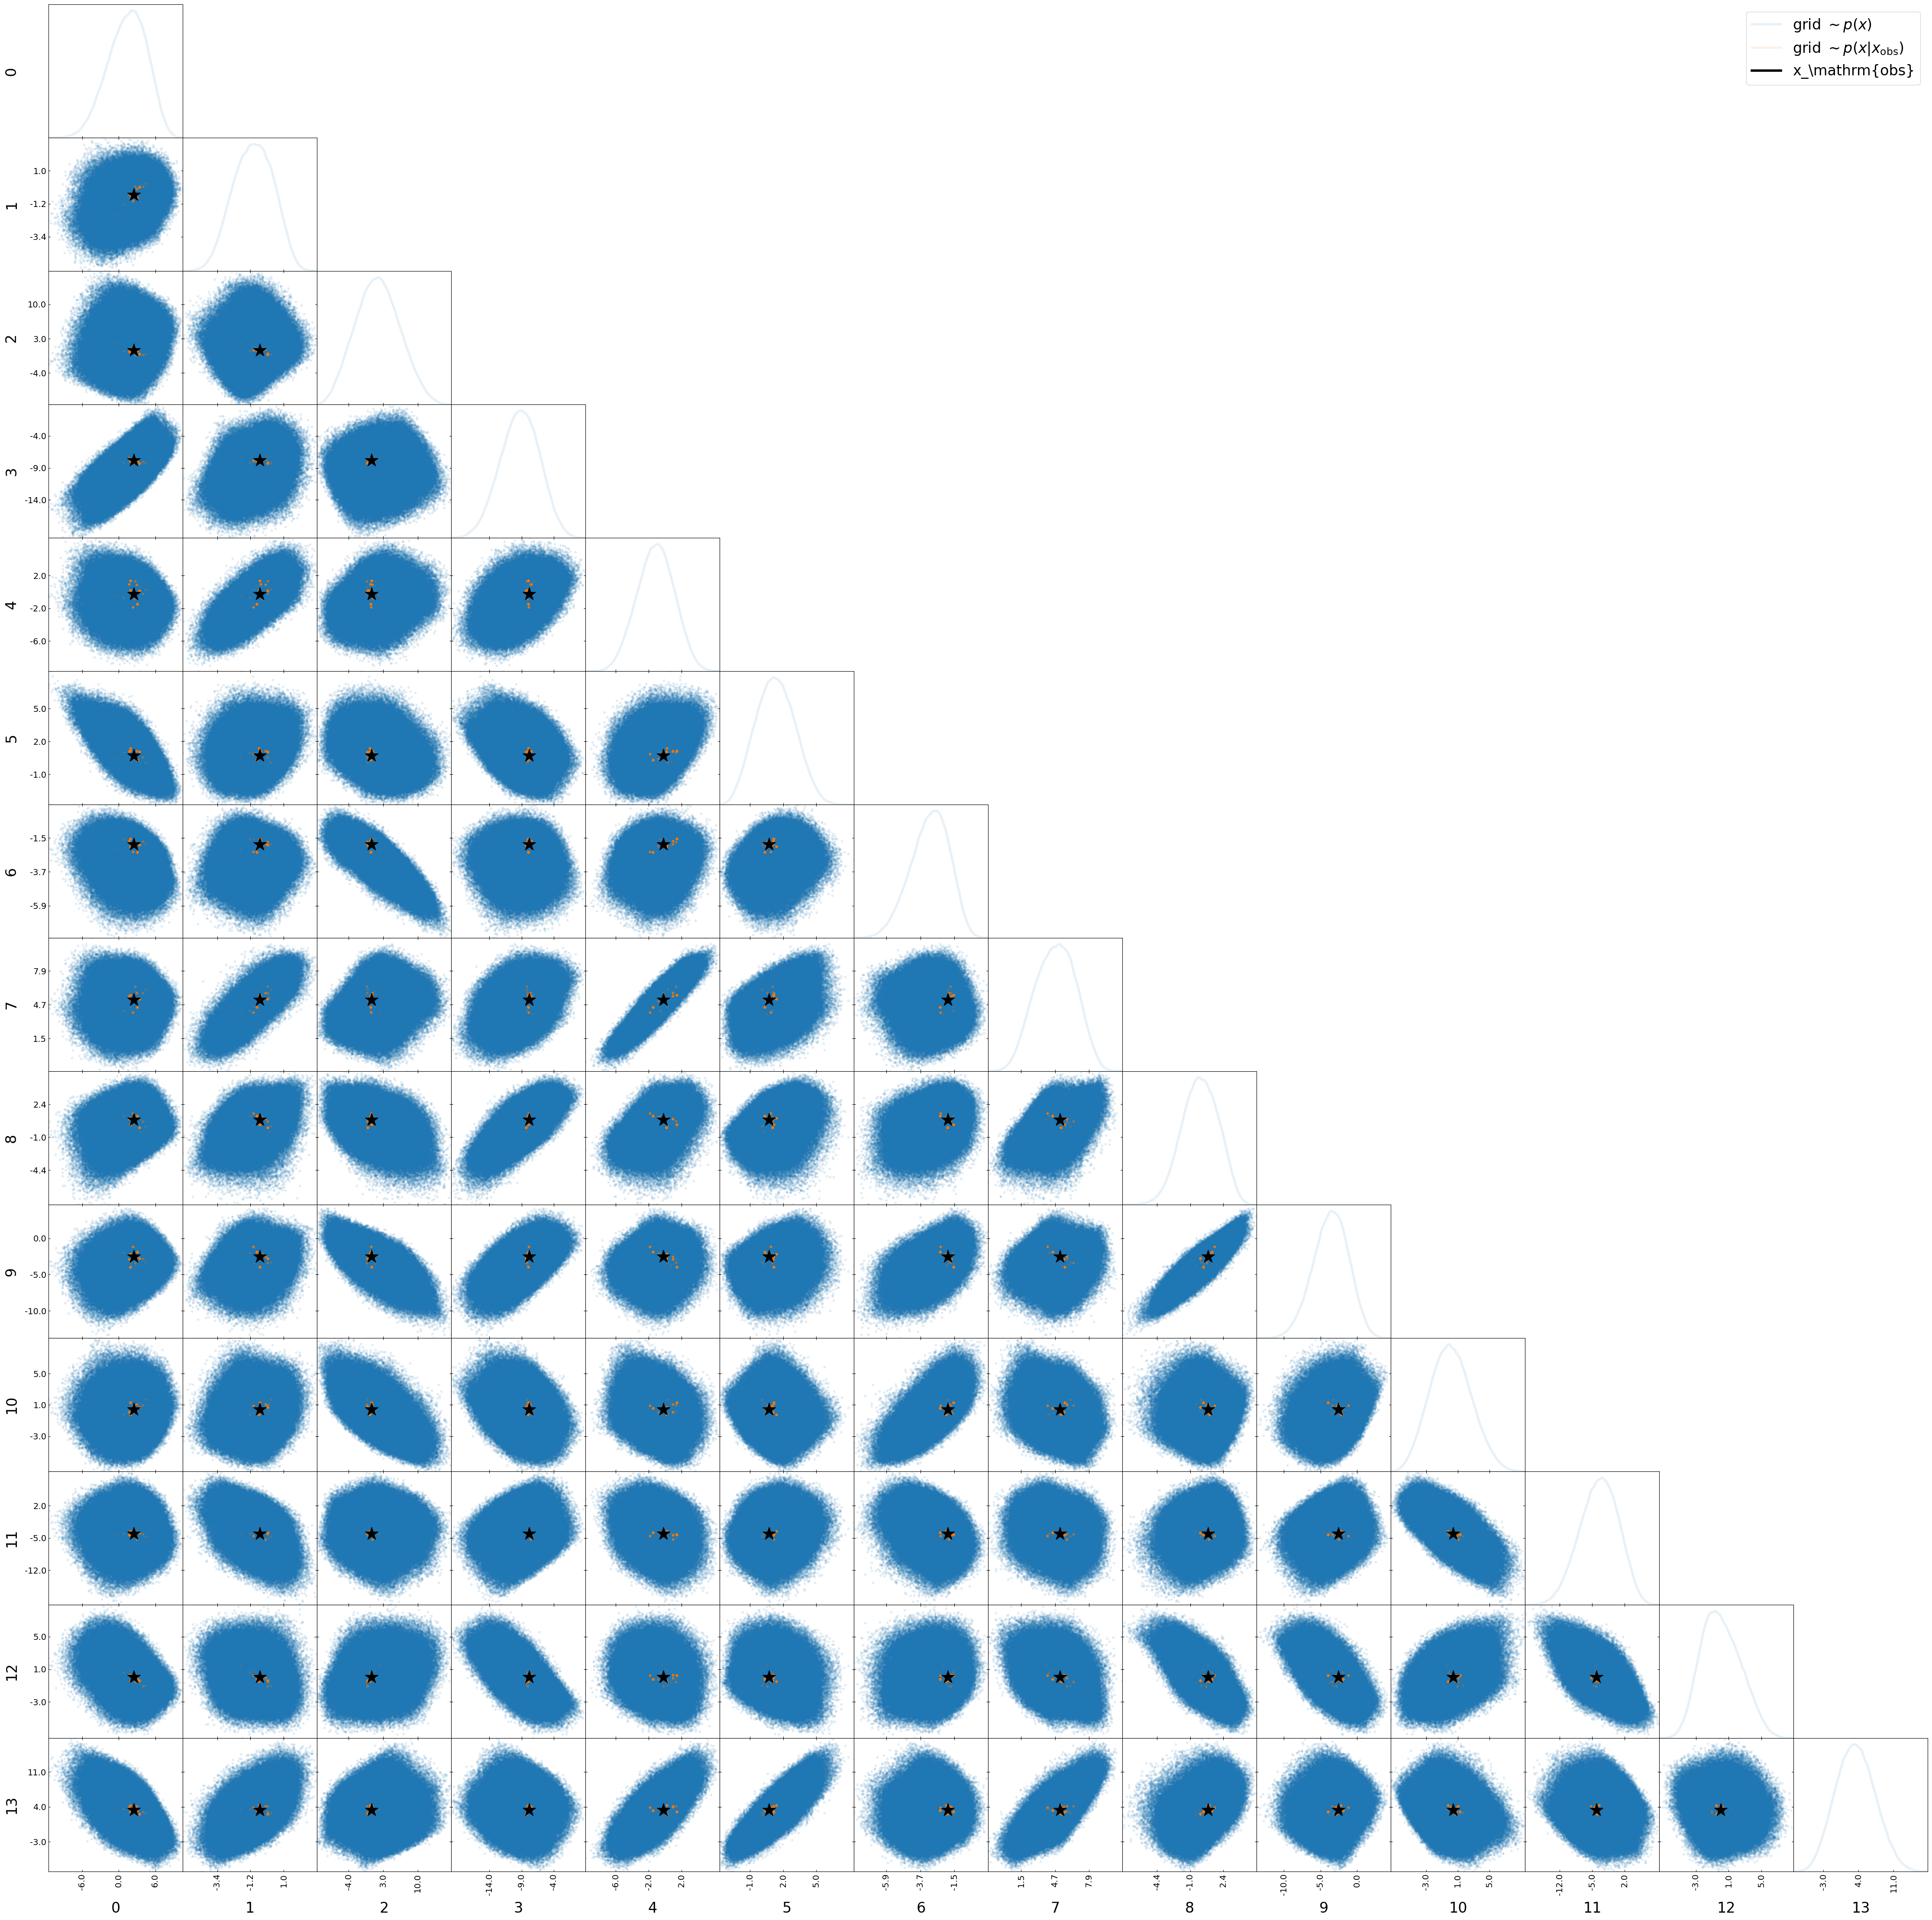

In [14]:
tri = TriangleChain()
tri.scatter(
    grid_preds, 
    scatter_kwargs={"s": 10, "marker": "o"},
    color="tab:blue",
    alpha=0.1,
    label=r"grid $\sim p(x)$",
)
tri.scatter(
    grid_pred_samples, 
    scatter_kwargs={"s": 10, "marker": "o"},
    color="tab:orange",
    label=r"grid $\sim p(x|x_\mathrm{obs})$",
    alpha=0.1,
)
tri.scatter(
    np.array(obs_pred), 
    scatter_kwargs={"s": 500, "marker": "*"},
    color="k",
    label=r"x_\mathrm{obs}",
    show_legend=True,
);

# tri.fig.savefig(f"plots/ppc_compression_Buzzard_{i_buzzard}.png", dpi=100)
# tri.fig.savefig(f"plots/ppc_compression_Buzzard_{i_buzzard}.pdf")

## $C_\ell$-level

In [15]:
# with_lensing_plot = with_lensing
# with_clustering_plot = with_clustering

with_lensing_plot = not with_lensing
with_clustering_plot = not with_clustering

25-08-04 11:24:53 configuratio INF   Loaded the config 
25-08-04 11:24:53 preprocessin INF   Using theta_fwhm = [22.1, 15.1, 11.2, 9.4, 130.2, 88.9, 68.1, 57.0] from the dlss config 
25-08-04 11:24:53 preprocessin INF   Using white_noise_sigma = [0.0010012, 0.0013444, 0.0016358, 0.0017096, 0.85135, 0.34375, 0.25989, 0.24127] from the dlss config 
25-08-04 11:24:53 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:24:53 preprocessin INF   Using l_mins = [0. 0. 0. 0. 0. 0. 0. 0.] by default (no smoothing) 
25-08-04 11:24:53 preprocessin INF   Using n_bins = 33 from the msfm config 
25-08-04 11:24:53 preprocessin INF   Loading the pre-binned Cls 
25-08-04 11:24:53 input_output INF   Loading summaries from /pscratch/sd/a/athomsen/v11desy3/v14/extended 
25-08-04 11:24:53 input_output INF   Array shapes: 
25-08-04 11:24:53 input_output INF   fiducial/i_example 

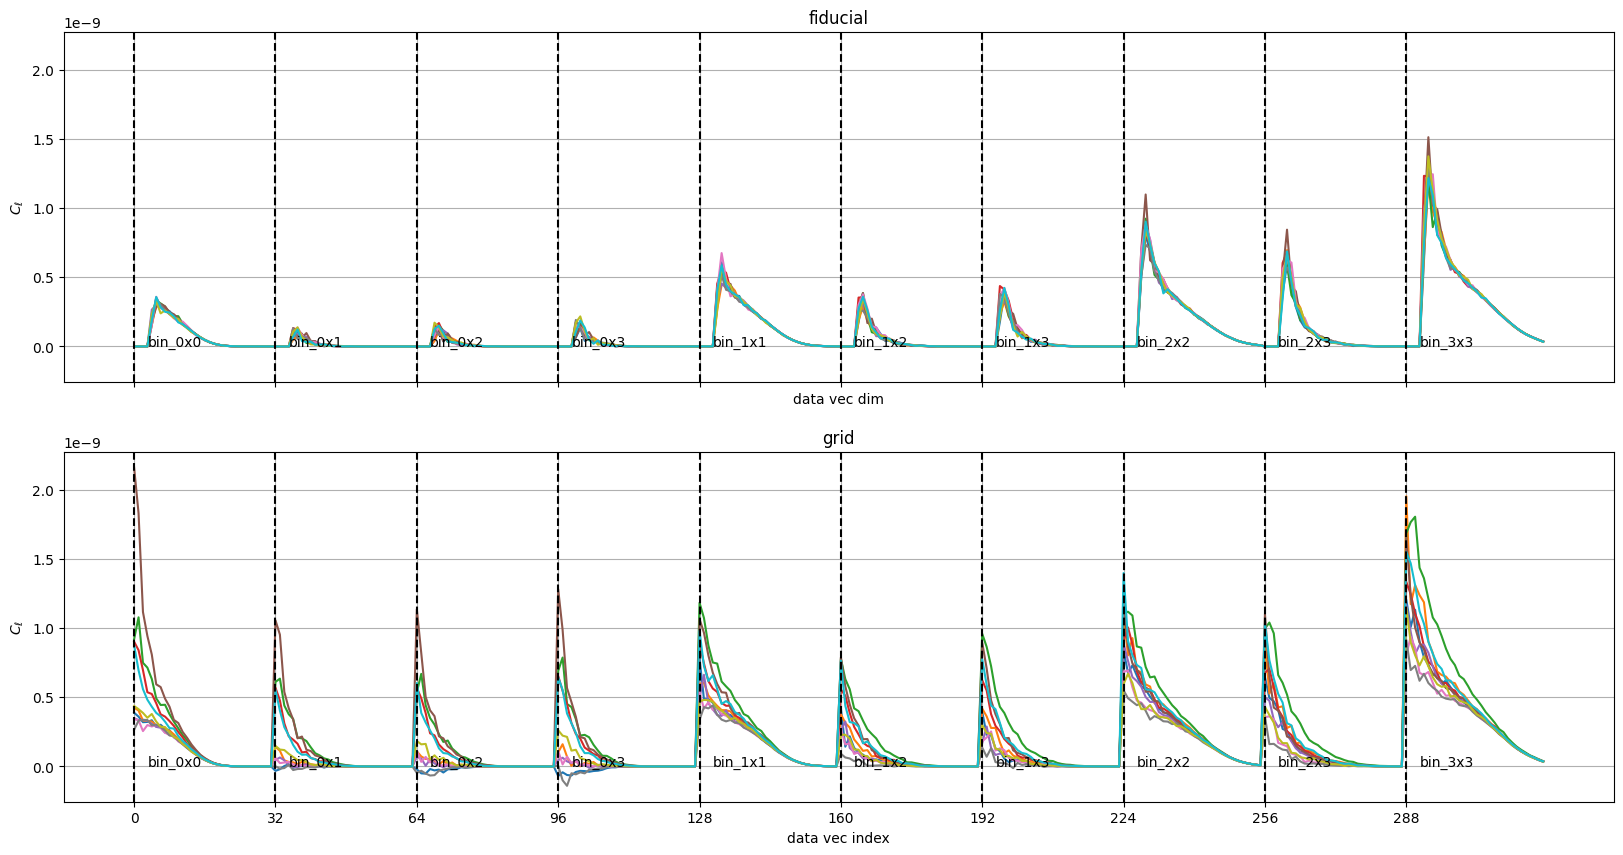

In [16]:
out_dict = preprocessing.get_binned_power_spectra(
    base_dir, 
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    params=params,
    # selection
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
    with_gaussian_noise=True,
    # preprocessing
    apply_log=False,
    standardize=False,
    concat_bin_dim=True,
)

fidu_cls, grid_cls, grid_cosmos_cls = out_dict["fidu/cls"], out_dict["grid/cls/test"], out_dict["grid/cosmos/test"]
print("grid_cls.shape", grid_cls.shape)
print("fidu_cls.shape", fidu_cls.shape)

assert np.allclose(grid_cosmos, grid_cosmos_cls)

In [17]:
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
)

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
print(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

[  30.           42.46307239   57.08578528   73.86813865   92.81013252
  113.91176687  137.17304172  162.59395706  190.17451288  219.9147092
  251.81454601  285.87402331  322.0931411   360.47189939  401.01029816
  443.70833742  488.56601718  535.58333742  584.76029816  636.09689939
  689.5931411   745.24902331  803.06454601  863.0397092   925.17451288
  989.46895706 1055.92304172 1124.53676687 1195.31013252 1268.24313865
 1343.33578528 1420.58807239 1500.        ]


### load Buzzard

In [18]:
def get_obs_cls(lensing_file, clustering_file, nest_in=False):
    # load the mock
    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)

    with h5py.File(clustering_file, "r") as f_in:
        gc_map = []
        for i in range(1,5):
            gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
        gc_map = np.stack(gc_map, axis=-1)

    # forward model
    obs_cls = preprocessing.get_preprocessed_cl_observation(
        wl_gamma_map=wl_map,
        gc_count_map=gc_map,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        nest_in=False,
        make_plot=False,
        # selection
        with_lensing=with_lensing_plot,
        with_clustering=with_clustering_plot,
        with_cross_z=True,
        # additional preprocessing
        apply_log=False,
        standardize=False,
    )

    return np.squeeze(obs_cls)


In [19]:
buzzard_cls = []
I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
K = ["a"] + 7 * ["a", "b"]

if i_buzzard == "mean":
    iterator = zip(I, J, K)
elif isinstance(i_buzzard, int):
    iterator = [list(zip(I, J, K))[i_buzzard]]
else:
    raise RuntimeError

for i, j, k in tqdm(iterator):
    lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
    clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
    buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

if i_buzzard == "mean":
    buzzard_cls = np.stack(buzzard_cls, axis=0)
    buzzard_cls = np.mean(buzzard_cls, axis=0)
elif isinstance(i_buzzard, int):
    buzzard_cls = np.squeeze(buzzard_cls)
else:
    raise RuntimeError

0it [00:00, ?it/s]

25-08-04 11:25:12 configuratio INF   Loaded the config 
25-08-04 11:25:12 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:12 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:25:19 preprocessin INF   Adding white noise to the observation 
25-08-04 11:25:19 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


1it [00:07,  7.39s/it]

25-08-04 11:25:19 configuratio INF   Loaded the config 
25-08-04 11:25:19 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:19 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:25:25 preprocessin INF   Adding white noise to the observation 
25-08-04 11:25:25 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


2it [00:13,  6.78s/it]

25-08-04 11:25:25 configuratio INF   Loaded the config 
25-08-04 11:25:25 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:25 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:25:31 preprocessin INF   Adding white noise to the observation 
25-08-04 11:25:31 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


3it [00:20,  6.62s/it]

25-08-04 11:25:32 configuratio INF   Loaded the config 
25-08-04 11:25:32 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:32 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:25:38 preprocessin INF   Adding white noise to the observation 
25-08-04 11:25:38 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


4it [00:26,  6.56s/it]

25-08-04 11:25:38 configuratio INF   Loaded the config 
25-08-04 11:25:38 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:38 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:25:44 preprocessin INF   Adding white noise to the observation 
25-08-04 11:25:44 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


5it [00:33,  6.49s/it]

25-08-04 11:25:45 configuratio INF   Loaded the config 
25-08-04 11:25:45 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:45 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:25:51 preprocessin INF   Adding white noise to the observation 
25-08-04 11:25:51 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


6it [00:39,  6.44s/it]

25-08-04 11:25:51 configuratio INF   Loaded the config 
25-08-04 11:25:51 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:51 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:25:57 preprocessin INF   Adding white noise to the observation 
25-08-04 11:25:57 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


7it [00:45,  6.45s/it]

25-08-04 11:25:57 configuratio INF   Loaded the config 
25-08-04 11:25:57 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:25:57 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:04 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:04 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


8it [00:52,  6.44s/it]

25-08-04 11:26:04 configuratio INF   Loaded the config 
25-08-04 11:26:04 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:26:04 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:10 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:10 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


9it [00:58,  6.43s/it]

25-08-04 11:26:10 configuratio INF   Loaded the config 
25-08-04 11:26:10 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:26:10 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:16 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:16 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


10it [01:04,  6.39s/it]

25-08-04 11:26:16 configuratio INF   Loaded the config 
25-08-04 11:26:16 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:26:16 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:22 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:22 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


11it [01:11,  6.34s/it]

25-08-04 11:26:23 configuratio INF   Loaded the config 
25-08-04 11:26:23 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:26:23 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:29 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:29 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


12it [01:17,  6.34s/it]

25-08-04 11:26:29 configuratio INF   Loaded the config 
25-08-04 11:26:29 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:26:29 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:35 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:35 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


13it [01:23,  6.34s/it]

25-08-04 11:26:35 configuratio INF   Loaded the config 
25-08-04 11:26:35 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:26:35 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:41 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:41 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


14it [01:30,  6.31s/it]

25-08-04 11:26:42 configuratio INF   Loaded the config 
25-08-04 11:26:42 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-08-04 11:26:42 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-08-04 11:26:48 preprocessin INF   Adding white noise to the observation 
25-08-04 11:26:48 preprocessin INF   Using the bin indices [ 0  1  2  3  8  9 10 15 16 21] 


15it [01:37,  6.47s/it]


### plotting

In [20]:
def reshape_full_cls(obs_cls, with_lensing=True, with_clustering=True, concat_bins=True):
    obs_cls_reshaped = np.stack(np.split(obs_cls, 36, axis=-1), axis=-1)

    total_indices, names = cross_statistics.get_cross_bin_indices(
        with_lensing=with_lensing, with_clustering=with_clustering, with_cross_z=True,
    )
    obs_cls_selected = obs_cls_reshaped[:,total_indices]

    if concat_bins:
        obs_cls_selected = np.concatenate([obs_cls_selected[..., i] for i in range(obs_cls_selected.shape[-1])], axis=-1)

    return obs_cls_selected

def reshape_probe_cls(obs_cls):
    return np.stack(np.split(obs_cls, 10, axis=-1), axis=-1)    


In [21]:
n_z = 4 * with_lensing_plot + 4 * with_clustering_plot

cosmogrid_cls_reshaped = reshape_probe_cls(grid_cls[i_samples])
buzzard_cls_reshaped = reshape_probe_cls(buzzard_cls)

bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
    with_cross_z=True,
)

### samples

In [22]:
# # remove_l_min = True
# figsize = (24, 16)
# # figsize = (12, 8)
# fig, ax = plt.subplots(figsize=figsize, nrows=n_z, ncols=n_z, sharex=True, sharey=False)

# for k, bin_name in enumerate(bin_names):
#     j, i = int(bin_name[-3]), int(bin_name[-1])
#     if not with_lensing_plot and with_clustering_plot:
#         i -= 4
#         j -= 4

#     current_bins = bin_centers
#     current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
#     current_buzzard = buzzard_cls_reshaped[:, k]
    
#     # if remove_l_min:
#     #     current_bins = bins[5:]
#     #     current_cosmogrid = current_cosmogrid[4:]
#     #     current_buzzard = current_buzzard[4:]
#     # else:
#     #     current_bins = bins[1:]

#     # ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0) 
    
#     # for cls, alpha in zip(current_cosmogrid.T, unique_alphas):
#     #     ax[i,j].plot(current_bins, current_bins * cls, alpha=alpha, color="tab:blue") 
    
#     for cls in current_cosmogrid.T:
#         ax[i,j].plot(current_bins, current_bins * cls, alpha=0.01, color="tab:blue") 
        
#     ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
    
#     # label
#     bin_i = rf"\delta_g^{i+1}"
#     bin_j = rf"\delta_g^{j+1}"
#     bin_label = f"${bin_j}$ x ${bin_i}$"
#     ax[i, j].text(
#         0.95, 0.93, bin_label,
#         transform=ax[i, j].transAxes,
#         fontsize='xx-large',
#         ha='right', va='top'
#     )

#     # cosmetics
#     ax[i, j].set_box_aspect(2 / 3)
#     ax[i, j].grid(True, zorder=0)
#     ax[i, j].set(xscale="log")
#     if i == n_z - 1:
#         ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
#     if j == 0:
#         ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")

# # Turn off upper triangle
# for i in range(n_z):
#     for j in range(i + 1, n_z):
#         ax[i, j].axis('off')

# # fig.legend()
# fig.tight_layout()

# fig.savefig(f"plots/ppc_cls_Buzzard_{i_buzzard}_samples.png", bbox_inches="tight", dpi=100)

### bands

In [23]:
# def weighted_quantile(a, w, q):
#     # a: shape (G,), w normalised to sum to 1, q in [0,1]
#     sorter = np.argsort(a)
#     a, w = a[sorter], w[sorter]
#     cum = np.cumsum(w)
#     return np.interp(q, cum, a)

import numpy as np
from numpy.typing import ArrayLike
from typing import Union, Sequence

def weighted_quantile(a: ArrayLike,
                      w: ArrayLike,
                      q: Union[float, Sequence[float]],
                      axis: int = 0):
    """
    Weighted quantile(s) of `a` along a given axis.

    Parameters
    ----------
    a : array_like
        Data array of shape (..., n_samples, ...).
    w : 1-D array_like
        Non-negative weights for the `n_samples` axis.  Need not be normalised.
    q : float or 1-D sequence of float
        Quantile level(s) in [0, 1].  `0.5` gives the weighted median.
    axis : int, default 0
        Axis of `a` that corresponds to the weight vector.

    Returns
    -------
    quantiles : ndarray
        Array whose first dimension is `len(q)` and whose remaining
        dimensions are those of `a` without the `axis` dimension.
        If `q` is a scalar the first dimension is squeezed away.
    """
    a = np.asarray(a)
    w = np.asarray(w, dtype=float)
    q = np.atleast_1d(q)

    # --- sanity checks ----------------------------------------------------
    if w.ndim != 1:
        raise ValueError("w must be 1-D")
    if a.shape[axis] != w.shape[0]:
        raise ValueError("len(w) must match a.shape[axis]")
    if np.any(q < 0) or np.any(q > 1):
        raise ValueError("q must be in [0, 1]")

    # --- move the weighted axis to the front ------------------------------
    if axis != 0:
        a = np.moveaxis(a, axis, 0)

    # --- normalise weights and broadcast over remaining dims -------------
    w = w / w.sum()
    # shape (n_samples, 1, 1, ...)
    w_b = w[(slice(None),) + (None,)* (a.ndim - 1)]

    # --- sort along the samples axis -------------------------------------
    sorter = np.argsort(a, axis=0)
    a_sorted = np.take_along_axis(a, sorter, axis=0)
    w_sorted = np.take_along_axis(w_b, sorter, axis=0)

    # --- cumulative weight (CDF) -----------------------------------------
    cdf = np.cumsum(w_sorted, axis=0)

    # --- interpolate for every trailing cell -----------------------------
    # output shape: (len(q), ...)  where ... are the trailing dims
    out_shape = (q.size,) + a_sorted.shape[1:]
    quantiles = np.empty(out_shape, dtype=a.dtype)

    # vectorised interpolation: loop only over trailing indices
    it = np.nditer(a_sorted[0], flags=['multi_index'])
    while not it.finished:
        sl = (slice(None),) + it.multi_index      # slice for this column
        quantiles[(slice(None),) + it.multi_index] = np.interp(
            q, cdf[sl], a_sorted[sl]
        )
        it.iternext()

    # --- restore original axis order -------------------------------------
    if axis != 0:
        # bring the quantile axis to the original axis location (+1 because of q-axis)
        quantiles = np.moveaxis(quantiles, 1, axis)

    # squeeze if q was scalar
    if quantiles.shape[0] == 1:
        quantiles = np.squeeze(quantiles, 0)

    return quantiles

In [24]:
cosmogrid_cls_reshaped = reshape_probe_cls(grid_cls)
buzzard_cls_reshaped = reshape_probe_cls(buzzard_cls)

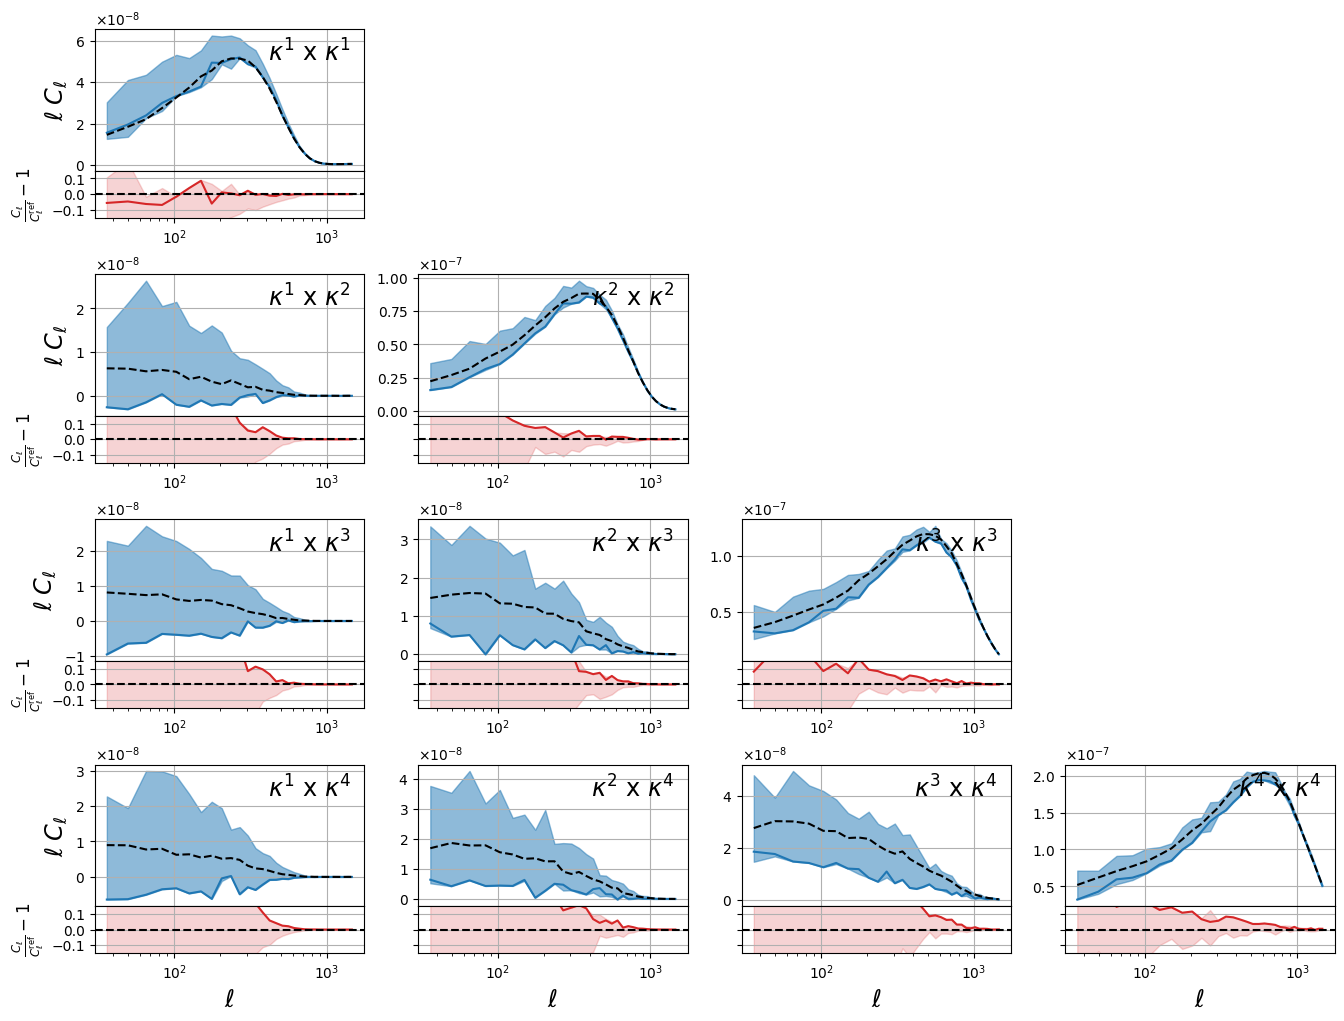

In [25]:
if with_lensing_plot:
    i_lmax = None
    eps = 1e-10
elif with_clustering_plot:
    i_lmax = -18
    eps = 1e-5
    
remove_l_max = True
remove_l_max = False

# figsize = (24, 20)
figsize = (16, 12)
fig = plt.figure(figsize=figsize)

# Create the outer gridspec - one cell per plot pair
outer_gs = fig.add_gridspec(n_z, n_z, hspace=0.3, wspace=0.2)

# Create empty 2D arrays for main axes and residual axes
ax = np.empty((n_z, n_z), dtype=object)
res_ax = np.empty((n_z, n_z), dtype=object)

# Create nested gridspecs and subplots
for i in range(n_z):
    for j in range(n_z):
        if i < j:  # Upper triangle - no plot
            continue
            
        # Create a nested gridspec for this plot pair with no internal spacing
        inner_gs = outer_gs[i, j].subgridspec(2, 1, height_ratios=[3, 1], hspace=0)
        
        # Main plot
        ax[i, j] = fig.add_subplot(inner_gs[0])
        
        # Residual plot (shares x-axis with main plot)
        res_ax[i, j] = fig.add_subplot(inner_gs[1], sharex=ax[i, j])

for k, bin_name in enumerate(bin_names):
    j, i = int(bin_name[-3]), int(bin_name[-1])
    if not with_lensing_plot and with_clustering_plot:
        i -= 4
        j -= 4
    
    if i < j:  # Skip upper triangle
        continue

    current_bins = bin_centers
    current_cosmogrid = cosmogrid_cls_reshaped[:, :, k]
    current_buzzard = buzzard_cls_reshaped[:, k]
    
    if i_lmax is not None:
        current_bins = current_bins[:i_lmax]
        current_cosmogrid = current_cosmogrid[:, :i_lmax]
        current_buzzard = current_buzzard[:i_lmax]
        

    # Calculate quantiles for central 2 sigma interval
    q_lower = weighted_quantile(current_cosmogrid, prob_samples, 0.02275, axis=0)
    q_median = weighted_quantile(current_cosmogrid, prob_samples, 0.5, axis=0)
    q_upper = weighted_quantile(current_cosmogrid, prob_samples, 0.97725, axis=0)
    
    # Plot main data
    ax[i, j].plot(current_bins, current_bins * q_median, alpha=1.0, color="tab:blue")
    ax[i, j].fill_between(current_bins, current_bins * q_lower, current_bins * q_upper, alpha=0.5, color="tab:blue")
    ax[i, j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
    
    # Plot normalized residuals: (Buzzard - q50)/Buzzard
    normalized_residuals = (current_buzzard - q_median) / (current_buzzard + eps)
    res_ax[i, j].plot(current_bins, normalized_residuals, color="tab:red")
    res_ax[i, j].axhline(y=0, color='k', linestyle='--', alpha=1.0)
    
    # Calculate normalized confidence band for 2 sigma
    lower_norm = (current_buzzard - q_upper) / (current_buzzard + eps)
    upper_norm = (current_buzzard - q_lower) / (current_buzzard + eps)
    res_ax[i, j].fill_between(
        current_bins,
        lower_norm,
        upper_norm,
        alpha=0.2,
        color="tab:red"
    )    
    
    max_abs_residual = np.max(np.abs(normalized_residuals))
    # res_ax[i,j].set_ylim(-max_abs_residual*1.1, max_abs_residual*1.1)
    res_ax[i,j].set_ylim(-0.15, 0.15)

    # Label
    if with_lensing_plot:
        bin_i = rf"\kappa^{i+1}"
        bin_j = rf"\kappa^{j+1}"
    elif with_clustering_plot:
        bin_i = rf"\delta_g^{i+1}"
        bin_j = rf"\delta_g^{j+1}"
    
    bin_label = f"${bin_j}$ x ${bin_i}$"
    ax[i, j].text(
        0.95, 
        0.93, 
        bin_label,
        transform=ax[i, j].transAxes,
        fontsize='xx-large',
        ha='right',
        va='top'
    )

    # Cosmetics for main plot
    ax[i, j].grid(True, zorder=0)
    ax[i, j].set(xscale="log")
    
    # Hide x-axis labels for main plot
    ax[i, j].tick_params(labelbottom=False)
        
    # Y-axis label for leftmost plots
    if j == 0:
        ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")
        res_ax[i, j].set_ylabel(r"$\frac{C_\ell}{C_\ell^\mathrm{ref}} - 1$", fontsize="large")  # Updated for normalized residuals
    
    # X-axis label for bottom plots
    if i == n_z - 1:
        res_ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
    
    # Cosmetics for residual plot
    res_ax[i, j].grid(True)
    res_ax[i, j].set(xscale="log")

# Turn off upper triangle completely
for i in range(n_z):
    for j in range(i + 1, n_z):
        if 'axis' in dir(ax[i, j]):
            ax[i, j].axis('off')
        if 'axis' in dir(res_ax[i, j]):
            res_ax[i, j].axis('off')
        
from matplotlib.ticker import ScalarFormatter, PercentFormatter
# Format the main plot y-axis with scientific notation
for i in range(n_z):
    for j in range(n_z):
        if i >= j:  # Only lower triangle
            # Configure scientific notation for main plots
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            ax[i, j].yaxis.set_major_formatter(formatter)
            
#             res_ax[i, j].yaxis.offsetText.set_visible(False)
            
#             # Format residual plots as percentages
#             percent_formatter = PercentFormatter(xmax=1.0, decimals=0)
#             res_ax[i, j].yaxis.set_major_formatter(percent_formatter)
            
#             # Set specific ticks for residual plots (-10%, 0%, 10%)
#             res_ax[i, j].set_yticks([-0.1, 0, 0.1])
            
            # Hide y-tick labels for all columns except the leftmost one
            if j > 0:  # Not in the leftmost column
                res_ax[i, j].tick_params(labelleft=False)

if with_lensing:
    ppc_label = "lensing"
elif with_clustering:
    ppc_label = "clustering"

if with_lensing_plot:
    cls_label = "lensing"
elif with_clustering_plot:
    cls_label = "clustering"

fig.savefig(f"plots/ppc={ppc_label}_cls={cls_label}_Buzzard_{i_buzzard}.png", bbox_inches="tight", dpi=100)

# fig.savefig(f"plots/ppc_cls_Buzzard_{i_buzzard}.png", bbox_inches="tight", dpi=100)
# fig.savefig(f"plots/ppc_cls_Buzzard_{i_buzzard}.pdf", bbox_inches="tight")

In [26]:
stop

NameError: name 'stop' is not defined

# cross-probe map-level summary

In [ ]:
grid_cosmos.shape

In [ ]:
grid_cosmos_plot.shape

In [ ]:
grid_cosmos_cls.shape

In [ ]:
if with_lensing and not with_clustering:    
    file_label = "32mpc"
    dlss_conf = configuration.load_deep_lss_config(
        f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/clustering/smoothing_fwhm/dlss_{file_label}.yaml"
    )
    
    # maps
    # classic-frost-1096 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/fp2vxm07/overview)
    # first v14 clustering probes run
    model_dir_plot = "/pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default"
    n_steps_maps_plot = 240_000
elif not with_lensing and with_clustering:     
    file_label = "8mpc"
    dlss_conf = configuration.load_deep_lss_config(
        f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/lensing/smoothing_fwhm/dlss_{file_label}.yaml"
    )
        
    # maps
    # young-serenity-1089 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/3g0z8qob/overview)
    # first v14 run
    model_dir_plot = "/pscratch/sd/a/athomsen/run_files/v14/extended/lensing/mutual_info/2025-04-19_18-54-31_deepsphere_default"
    n_steps_maps_plot = 400_000

_, grid_preds_plot, grid_cosmos_plot, _ = preprocessing.get_reshaped_network_preds(
    "",
    model_dir_plot,
    n_steps_maps_plot,
)

_, grid_pred_samples_plot, _, _ = sample_from_log_probs(
    grid_preds_plot,
    log_probs,
    1_000,
)

assert np.allclose(grid_cosmos[:,:3], grid_cosmos_plot[:,:3])
assert np.allclose(grid_cosmos_cls[:,:3], grid_cosmos_plot[:,:3])

In [ ]:
tri = TriangleChain()
tri.scatter(
    grid_preds_plot, 
    scatter_kwargs={"s": 10, "marker": "o"},
    color="tab:blue",
    alpha=0.1,
    label=r"grid $\sim p(x)$",
)
tri.scatter(
    grid_pred_samples_plot, 
    scatter_kwargs={"s": 10, "marker": "o"},
    color="tab:orange",
    label=r"grid $\sim p(x|x_\mathrm{obs})$",
    alpha=0.1,
)
# tri.scatter(
#     np.array(obs_pred), 
#     scatter_kwargs={"s": 500, "marker": "*"},
#     color="k",
#     label=r"x_\mathrm{obs}",
#     show_legend=True,
# );

# tri.fig.savefig(f"plots/ppc_compression_Buzzard_{i_buzzard}.png", dpi=100)
# tri.fig.savefig(f"plots/ppc_compression_Buzzard_{i_buzzard}.pdf")